# Pretrained Vectors - Neural Network Classifier

In this notebook, we try various merging strategies to merge the vectors for image pair inputs and try to predict similarity using a fully connected neural network front end.

In [1]:
from __future__ import division, print_function
from keras import backend as K
from keras.layers import Input
from keras.callbacks import ModelCheckpoint
from keras.layers.core import Activation, Dense, Dropout, Lambda
from keras.layers.merge import Concatenate
from keras.models import Model, load_model
from keras.utils import np_utils
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_DIR = "../data"
IMAGE_DIR = os.path.join(DATA_DIR, "holiday-photos")

BATCH_SIZE = 32
NUM_EPOCHS = 10

In [3]:
def get_holiday_triples(image_dir):
    image_groups = {}
    for image_name in os.listdir(image_dir):
        base_name = image_name[0:-4]
        group_name = base_name[0:4]
        if image_groups.has_key(group_name):
            image_groups[group_name].append(image_name)
        else:
            image_groups[group_name] = [image_name]
    num_sims = 0
    image_triples = []
    group_list = sorted(list(image_groups.keys()))
    for i, g in enumerate(group_list):
        if num_sims % 100 == 0:
            print("Generated {:d} pos + {:d} neg = {:d} total image triples"
                  .format(num_sims, num_sims, 2*num_sims))
        images_in_group = image_groups[g]
        sim_pairs_it = itertools.combinations(images_in_group, 2)
        # for each similar pair, generate a corresponding different pair
        for ref_image, sim_image in sim_pairs_it:
            image_triples.append((ref_image, sim_image, 1))
            num_sims += 1
            while True:
                j = np.random.randint(low=0, high=len(group_list), size=1)[0]
                if j != i:
                    break
            dif_image_candidates = image_groups[group_list[j]]
            k = np.random.randint(low=0, high=len(dif_image_candidates), size=1)[0]
            dif_image = dif_image_candidates[k]
            image_triples.append((ref_image, dif_image, 0))
    print("Generated {:d} pos + {:d} neg = {:d} total image triples"
          .format(num_sims, num_sims, 2*num_sims))
    return image_triples

def load_vectors(vector_file):
    vec_dict = {}
    fvec = open(vector_file, "rb")
    for line in fvec:
        image_name, image_vec = line.strip().split("\t")
        vec = np.array([float(v) for v in image_vec.split(",")])
        vec_dict[image_name] = vec
    fvec.close()
    return vec_dict

def train_test_split(triples, splits):
    assert sum(splits) == 1.0
    split_pts = np.cumsum(np.array([0.] + splits))
    indices = np.random.permutation(np.arange(len(triples)))
    shuffled_triples = [triples[i] for i in indices]
    data_splits = []
    for sid in range(len(splits)):
        start = int(split_pts[sid] * len(triples))
        end = int(split_pts[sid + 1] * len(triples))
        data_splits.append(shuffled_triples[start:end])
    return data_splits

def batch_to_vectors(batch, vec_size, vec_dict):
    X1 = np.zeros((len(batch), vec_size))
    X2 = np.zeros((len(batch), vec_size))
    Y = np.zeros((len(batch), 2))
    for tid in range(len(batch)):
        X1[tid] = vec_dict[batch[tid][0]]
        X2[tid] = vec_dict[batch[tid][1]]
        Y[tid] = [1, 0] if batch[tid][2] == 0 else [0, 1]
    return ([X1, X2], Y)
    
def data_generator(triples, vec_size, vec_dict, batch_size=32):
    while True:
        # shuffle once per batch
        indices = np.random.permutation(np.arange(len(triples)))
        num_batches = len(triples) // batch_size
        for bid in range(num_batches):
            batch_indices = indices[bid * batch_size : (bid + 1) * batch_size]
            batch = [triples[i] for i in batch_indices]
            yield batch_to_vectors(batch, vec_size, vec_dict)

def evaluate_model(model_file, test_gen):
    model_name = os.path.basename(model_file)
    model = load_model(model_file)
    print("=== Evaluating model: {:s} ===".format(model_name))
    ytrue, ypred = [], []
    num_test_steps = len(test_triples) // BATCH_SIZE
    for i in range(num_test_steps):
        (X1, X2), Y = test_gen.next()
        Y_ = model.predict([X1, X2])
        ytrue.extend(np.argmax(Y, axis=1).tolist())
        ypred.extend(np.argmax(Y_, axis=1).tolist())
    accuracy = accuracy_score(ytrue, ypred)
    print("\nAccuracy: {:.3f}".format(accuracy))
    print("\nConfusion Matrix")
    print(confusion_matrix(ytrue, ypred))
    print("\nClassification Report")
    print(classification_report(ytrue, ypred))
    return accuracy

def get_model_file(data_dir, vector_name, merge_mode, borf):
    return os.path.join(data_dir, "models", "{:s}-{:s}-{:s}.h5"
                        .format(vector_name, merge_mode, borf))

## Declare and Extract Common Data

In [4]:
VECTORIZERS = ["InceptionV3", "ResNet"]
MERGE_MODES = ["Concat", "Dot", "AbsDiff", "Euclidean"]
scores = np.zeros((len(VECTORIZERS), len(MERGE_MODES)))

In [5]:
image_triples = get_holiday_triples(IMAGE_DIR)

Generated 0 pos + 0 neg = 0 total image triples
Generated 300 pos + 300 neg = 600 total image triples
Generated 1100 pos + 1100 neg = 2200 total image triples
Generated 1800 pos + 1800 neg = 3600 total image triples
Generated 2072 pos + 2072 neg = 4144 total image triples


In [6]:
train_triples, val_triples, test_triples = train_test_split(image_triples, 
                                                            splits=[0.7, 0.1, 0.2])
print(len(train_triples), len(val_triples), len(test_triples))

2900 415 829


# InceptionV3 Vectors

In [7]:
VECTOR_SIZE = 2048
VECTOR_FILE = os.path.join(DATA_DIR, "inception-vectors.tsv")

In [8]:
vec_dict = load_vectors(VECTOR_FILE)

## Input: Concatenate Vectors

In [9]:
train_gen = data_generator(train_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
val_gen = data_generator(val_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)

In [10]:
input_1 = Input(shape=(VECTOR_SIZE,))
input_2 = Input(shape=(VECTOR_SIZE,))
merged = Concatenate(axis=-1)([input_1, input_2])

fc1 = Dense(512, kernel_initializer="glorot_uniform")(merged)
fc1 = Dropout(0.2)(fc1)
fc1 = Activation("relu")(fc1)

fc2 = Dense(128, kernel_initializer="glorot_uniform")(fc1)
fc2 = Dropout(0.2)(fc2)
fc2 = Activation("relu")(fc2)

pred = Dense(2, kernel_initializer="glorot_uniform")(fc2)
pred = Activation("softmax")(pred)

In [11]:
model = Model(inputs=[input_1, input_2], outputs=pred)
# model.summary()

In [12]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [13]:
best_model_name = get_model_file(DATA_DIR, "inceptionv3", "cat", "best")
checkpoint = ModelCheckpoint(best_model_name, save_best_only=True)
train_steps_per_epoch = len(train_triples) // BATCH_SIZE
val_steps_per_epoch = len(val_triples) // BATCH_SIZE
history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, 
                              epochs=NUM_EPOCHS, 
                              validation_data=val_gen, validation_steps=val_steps_per_epoch,
                              callbacks=[checkpoint])

Epoch 1/10
90/90 [==============================] - 134s - loss: 0.5427 - acc: 0.7493 - val_loss: 0.3103 - val_acc: 0.8594

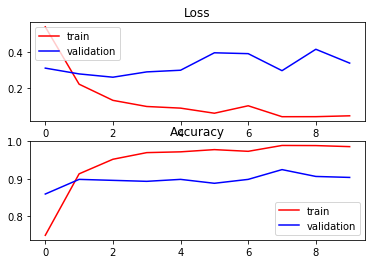

In [14]:
plt.subplot(211)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.show()

In [15]:
final_model_name = get_model_file(DATA_DIR, "inceptionv3", "cat", "final")
model.save(final_model_name)
test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
final_accuracy = evaluate_model(final_model_name, test_gen)

test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
best_accuracy = evaluate_model(best_model_name, test_gen)

scores[0, 0] = best_accuracy if best_accuracy > final_accuracy else final_accuracy

=== Evaluating model: inceptionv3-cat-final.h5 ===

Accuracy: 0.904

Confusion Matrix
[[371  58]
 [ 19 352]]

Classification Report
             precision    recall  f1-score   support

          0       0.95      0.86      0.91       429
          1       0.86      0.95      0.90       371

avg / total       0.91      0.90      0.90       800

=== Evaluating model: inceptionv3-cat-best.h5 ===

Accuracy: 0.901

Confusion Matrix
[[364  62]
 [ 17 357]]

Classification Report
             precision    recall  f1-score   support

          0       0.96      0.85      0.90       426
          1       0.85      0.95      0.90       374

avg / total       0.91      0.90      0.90       800



## Input: Elementwise Cosine Distance

In [16]:
train_gen = data_generator(train_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
val_gen = data_generator(val_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)

In [17]:
def cosine_distance(vecs, normalize=False):
    x, y = vecs
    if normalize:
        x = K.l2_normalize(x, axis=0)
        y = K.l2_normalize(x, axis=0)
    return K.prod(K.stack([x, y], axis=1), axis=1)

def cosine_distance_output_shape(shapes):
    return shapes[0]

vecs = [np.random.random((10,)), np.random.random((10,))]
print(vecs[0].shape, vecs[1].shape)
s = cosine_distance(vecs)
print(s.shape)

(10,) (10,)
(10,)


In [18]:
input_1 = Input(shape=(VECTOR_SIZE,))
input_2 = Input(shape=(VECTOR_SIZE,))
merged = Lambda(cosine_distance, 
                  output_shape=cosine_distance_output_shape)([input_1, input_2])

fc1 = Dense(512, kernel_initializer="glorot_uniform")(merged)
fc1 = Dropout(0.2)(fc1)
fc1 = Activation("relu")(fc1)

fc2 = Dense(128, kernel_initializer="glorot_uniform")(fc1)
fc2 = Dropout(0.2)(fc2)
fc2 = Activation("relu")(fc2)

pred = Dense(2, kernel_initializer="glorot_uniform")(fc2)
pred = Activation("softmax")(pred)

In [19]:
model = Model(inputs=[input_1, input_2], outputs=pred)
# model.summary()

In [20]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [21]:
best_model_name = get_model_file(DATA_DIR, "inceptionv3", "dot", "best")
checkpoint = ModelCheckpoint(best_model_name, save_best_only=True)
train_steps_per_epoch = len(train_triples) // BATCH_SIZE
val_steps_per_epoch = len(val_triples) // BATCH_SIZE
history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, 
                              epochs=NUM_EPOCHS, 
                              validation_data=val_gen, validation_steps=val_steps_per_epoch,
                              callbacks=[checkpoint])

Epoch 1/10
90/90 [==============================] - 1s - loss: 0.2495 - acc: 0.9066 - val_loss: 0.1786 - val_acc: 0.9297

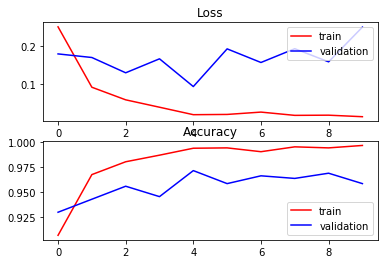

In [22]:
plt.subplot(211)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.show()

In [23]:
final_model_name = get_model_file(DATA_DIR, "inceptionv3", "dot", "final")
model.save(final_model_name)
test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
final_accuracy = evaluate_model(final_model_name, test_gen)

test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
best_accuracy = evaluate_model(best_model_name, test_gen)

scores[0, 1] = best_accuracy if best_accuracy > final_accuracy else final_accuracy

=== Evaluating model: inceptionv3-dot-final.h5 ===

Accuracy: 0.943

Confusion Matrix
[[392  38]
 [  8 362]]

Classification Report
             precision    recall  f1-score   support

          0       0.98      0.91      0.94       430
          1       0.91      0.98      0.94       370

avg / total       0.95      0.94      0.94       800

=== Evaluating model: inceptionv3-dot-best.h5 ===

Accuracy: 0.958

Confusion Matrix
[[398  26]
 [  8 368]]

Classification Report
             precision    recall  f1-score   support

          0       0.98      0.94      0.96       424
          1       0.93      0.98      0.96       376

avg / total       0.96      0.96      0.96       800



## Input: Elementwise Absolute Difference

In [24]:
train_gen = data_generator(train_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
val_gen = data_generator(val_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)

In [25]:
def absdiff(vecs):
    x, y = vecs
    return K.abs(K.sum(K.stack([x, -y], axis=1), axis=1))

def absdiff_output_shape(shapes):
    return shapes[0]

vecs = [np.random.random((10,)), np.random.random((10,))]
print(vecs[0].shape, vecs[1].shape)
s = absdiff(vecs)
print(s.shape)

(10,) (10,)
(10,)


In [26]:
input_1 = Input(shape=(VECTOR_SIZE,))
input_2 = Input(shape=(VECTOR_SIZE,))
merged = Lambda(absdiff, output_shape=absdiff_output_shape)([input_1, input_2])

fc1 = Dense(512, kernel_initializer="glorot_uniform")(merged)
fc1 = Dropout(0.2)(fc1)
fc1 = Activation("relu")(fc1)

fc2 = Dense(128, kernel_initializer="glorot_uniform")(fc1)
fc2 = Dropout(0.2)(fc2)
fc2 = Activation("relu")(fc2)

pred = Dense(2, kernel_initializer="glorot_uniform")(fc2)
pred = Activation("softmax")(pred)

In [27]:
model = Model(inputs=[input_1, input_2], outputs=pred)
# model.summary()

In [28]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [29]:
best_model_name = get_model_file(DATA_DIR, "inceptionv3", "l1", "best")
checkpoint = ModelCheckpoint(best_model_name, save_best_only=True)
train_steps_per_epoch = len(train_triples) // BATCH_SIZE
val_steps_per_epoch = len(val_triples) // BATCH_SIZE
history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, 
                              epochs=NUM_EPOCHS, 
                              validation_data=val_gen, validation_steps=val_steps_per_epoch,
                              callbacks=[checkpoint])

Epoch 1/10
90/90 [==============================] - 1s - loss: 0.6023 - acc: 0.6847 - val_loss: 0.4509 - val_acc: 0.8073

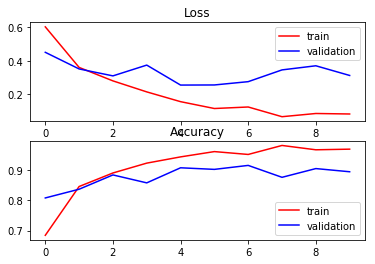

In [30]:
plt.subplot(211)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.show()

In [31]:
final_model_name = get_model_file(DATA_DIR, "inceptionv3", "l1", "final")
model.save(final_model_name)
test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
final_accuracy = evaluate_model(final_model_name, test_gen)

test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
best_accuracy = evaluate_model(best_model_name, test_gen)

scores[0, 2] = best_accuracy if best_accuracy > final_accuracy else final_accuracy

=== Evaluating model: inceptionv3-l1-final.h5 ===

Accuracy: 0.892

Confusion Matrix
[[389  37]
 [ 49 325]]

Classification Report
             precision    recall  f1-score   support

          0       0.89      0.91      0.90       426
          1       0.90      0.87      0.88       374

avg / total       0.89      0.89      0.89       800

=== Evaluating model: inceptionv3-l1-best.h5 ===

Accuracy: 0.889

Confusion Matrix
[[366  61]
 [ 28 345]]

Classification Report
             precision    recall  f1-score   support

          0       0.93      0.86      0.89       427
          1       0.85      0.92      0.89       373

avg / total       0.89      0.89      0.89       800



## Input: Elementwise Euclidean Distance

In [32]:
train_gen = data_generator(train_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
val_gen = data_generator(val_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)

In [33]:
def euclidean_distance(vecs):
    x, y = vecs
    return K.sqrt(K.sum(K.stack([K.square(x), -K.square(y)], axis=1), axis=1))

def euclidean_distance_output_shape(shapes):
    xshape, yshape = shapes
    return xshape

vecs = [np.random.random((10,)), np.random.random((10,))]
print(vecs[0].shape, vecs[1].shape)
s = euclidean_distance(vecs)
print(s.shape)

(10,) (10,)
(10,)


In [34]:
input_1 = Input(shape=(VECTOR_SIZE,))
input_2 = Input(shape=(VECTOR_SIZE,))
merged = Lambda(euclidean_distance, 
                output_shape=euclidean_distance_output_shape)([input_1, input_2])

fc1 = Dense(512, kernel_initializer="glorot_uniform")(merged)
fc1 = Dropout(0.2)(fc1)
fc1 = Activation("relu")(fc1)

fc2 = Dense(128, kernel_initializer="glorot_uniform")(fc1)
fc2 = Dropout(0.2)(fc2)
fc2 = Activation("relu")(fc2)

pred = Dense(2, kernel_initializer="glorot_uniform")(fc2)
pred = Activation("softmax")(pred)

In [35]:
model = Model(inputs=[input_1, input_2], outputs=pred)
# model.summary()

In [36]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [37]:
best_model_name = get_model_file(DATA_DIR, "inceptionv3", "l2", "best")
checkpoint = ModelCheckpoint(best_model_name, save_best_only=True)
train_steps_per_epoch = len(train_triples) // BATCH_SIZE
val_steps_per_epoch = len(val_triples) // BATCH_SIZE
history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, 
                              epochs=NUM_EPOCHS, 
                              validation_data=val_gen, validation_steps=val_steps_per_epoch,
                              callbacks=[checkpoint])

Epoch 1/10
90/90 [==============================] - 1s - loss: 0.7087 - acc: 0.5549 - val_loss: 0.6380 - val_acc: 0.6406

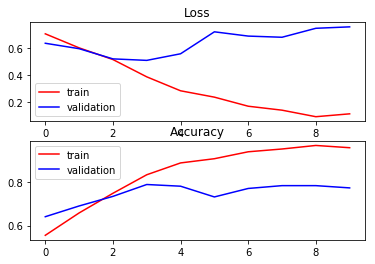

In [38]:
plt.subplot(211)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.show()

In [39]:
final_model_name = get_model_file(DATA_DIR, "inceptionv3", "l2", "final")
model.save(final_model_name)
test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
final_accuracy = evaluate_model(final_model_name, test_gen)

test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
best_accuracy = evaluate_model(best_model_name, test_gen)

scores[0, 3] = best_accuracy if best_accuracy > final_accuracy else final_accuracy

=== Evaluating model: inceptionv3-l2-final.h5 ===

Accuracy: 0.796

Confusion Matrix
[[343  79]
 [ 84 294]]

Classification Report
             precision    recall  f1-score   support

          0       0.80      0.81      0.81       422
          1       0.79      0.78      0.78       378

avg / total       0.80      0.80      0.80       800

=== Evaluating model: inceptionv3-l2-best.h5 ===

Accuracy: 0.772

Confusion Matrix
[[308 125]
 [ 57 310]]

Classification Report
             precision    recall  f1-score   support

          0       0.84      0.71      0.77       433
          1       0.71      0.84      0.77       367

avg / total       0.78      0.77      0.77       800



# ResNet 50 Vectors

In [40]:
VECTOR_SIZE = 2048
VECTOR_FILE = os.path.join(DATA_DIR, "resnet-vectors.tsv")

In [41]:
vec_dict = load_vectors(VECTOR_FILE)

## Input: Concatenate vectors

In [42]:
train_gen = data_generator(train_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
val_gen = data_generator(val_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)

In [43]:
input_1 = Input(shape=(VECTOR_SIZE,))
input_2 = Input(shape=(VECTOR_SIZE,))
merged = Concatenate(axis=-1)([input_1, input_2])

fc1 = Dense(512, kernel_initializer="glorot_uniform")(merged)
fc1 = Dropout(0.2)(fc1)
fc1 = Activation("relu")(fc1)

fc2 = Dense(128, kernel_initializer="glorot_uniform")(fc1)
fc2 = Dropout(0.2)(fc2)
fc2 = Activation("relu")(fc2)

pred = Dense(2, kernel_initializer="glorot_uniform")(fc2)
pred = Activation("softmax")(pred)

In [44]:
model = Model(inputs=[input_1, input_2], outputs=pred)
# model.summary()

In [45]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [46]:
best_model_name = get_model_file(DATA_DIR, "resnet50", "cat", "best")
checkpoint = ModelCheckpoint(best_model_name, save_best_only=True)
train_steps_per_epoch = len(train_triples) // BATCH_SIZE
val_steps_per_epoch = len(val_triples) // BATCH_SIZE
history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, 
                              epochs=NUM_EPOCHS, 
                              validation_data=val_gen, validation_steps=val_steps_per_epoch,
                              callbacks=[checkpoint])

Epoch 1/10
90/90 [==============================] - 1s - loss: 0.6717 - acc: 0.6396 - val_loss: 0.4275 - val_acc: 0.7865

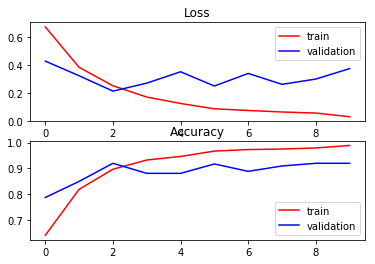

In [47]:
plt.subplot(211)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.show()

In [48]:
final_model_name = get_model_file(DATA_DIR, "resnet50", "cat", "final")
model.save(final_model_name)
test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
final_accuracy = evaluate_model(final_model_name, test_gen)

test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
best_accuracy = evaluate_model(best_model_name, test_gen)

scores[1, 0] = best_accuracy if best_accuracy > final_accuracy else final_accuracy

=== Evaluating model: resnet50-cat-final.h5 ===

Accuracy: 0.916

Confusion Matrix
[[370  52]
 [ 15 363]]

Classification Report
             precision    recall  f1-score   support

          0       0.96      0.88      0.92       422
          1       0.87      0.96      0.92       378

avg / total       0.92      0.92      0.92       800

=== Evaluating model: resnet50-cat-best.h5 ===

Accuracy: 0.874

Confusion Matrix
[[339  86]
 [ 15 360]]

Classification Report
             precision    recall  f1-score   support

          0       0.96      0.80      0.87       425
          1       0.81      0.96      0.88       375

avg / total       0.89      0.87      0.87       800



## Input: Elementwise Cosine Distance

In [49]:
train_gen = data_generator(train_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
val_gen = data_generator(val_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)

In [50]:
input_1 = Input(shape=(VECTOR_SIZE,))
input_2 = Input(shape=(VECTOR_SIZE,))
merged = Lambda(cosine_distance, 
                  output_shape=cosine_distance_output_shape)([input_1, input_2])

fc1 = Dense(512, kernel_initializer="glorot_uniform")(merged)
fc1 = Dropout(0.2)(fc1)
fc1 = Activation("relu")(fc1)

fc2 = Dense(128, kernel_initializer="glorot_uniform")(fc1)
fc2 = Dropout(0.2)(fc2)
fc2 = Activation("relu")(fc2)

pred = Dense(2, kernel_initializer="glorot_uniform")(fc2)
pred = Activation("softmax")(pred)

In [51]:
model = Model(inputs=[input_1, input_2], outputs=pred)
# model.summary()

In [52]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [53]:
best_model_name = get_model_file(DATA_DIR, "resnet50", "dot", "best")
checkpoint = ModelCheckpoint(best_model_name, save_best_only=True)
train_steps_per_epoch = len(train_triples) // BATCH_SIZE
val_steps_per_epoch = len(val_triples) // BATCH_SIZE
history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, 
                              epochs=NUM_EPOCHS, 
                              validation_data=val_gen, validation_steps=val_steps_per_epoch,
                              callbacks=[checkpoint])

Epoch 1/10
90/90 [==============================] - 1s - loss: 0.7144 - acc: 0.6847 - val_loss: 0.4144 - val_acc: 0.8542

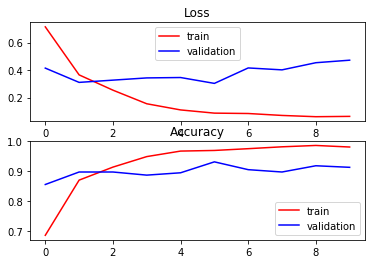

In [54]:
plt.subplot(211)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.show()

In [55]:
final_model_name = get_model_file(DATA_DIR, "resnet50", "dot", "final")
model.save(final_model_name)
test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
final_accuracy = evaluate_model(final_model_name, test_gen)

test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
best_accuracy = evaluate_model(best_model_name, test_gen)

scores[1, 1] = best_accuracy if best_accuracy > final_accuracy else final_accuracy

=== Evaluating model: resnet50-dot-final.h5 ===

Accuracy: 0.897

Confusion Matrix
[[379  44]
 [ 38 339]]

Classification Report
             precision    recall  f1-score   support

          0       0.91      0.90      0.90       423
          1       0.89      0.90      0.89       377

avg / total       0.90      0.90      0.90       800

=== Evaluating model: resnet50-dot-best.h5 ===

Accuracy: 0.890

Confusion Matrix
[[373  48]
 [ 40 339]]

Classification Report
             precision    recall  f1-score   support

          0       0.90      0.89      0.89       421
          1       0.88      0.89      0.89       379

avg / total       0.89      0.89      0.89       800



## Input: Elementwise Absolute Difference

In [56]:
train_gen = data_generator(train_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
val_gen = data_generator(val_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)

In [57]:
input_1 = Input(shape=(VECTOR_SIZE,))
input_2 = Input(shape=(VECTOR_SIZE,))
merged = Lambda(absdiff, output_shape=absdiff_output_shape)([input_1, input_2])

fc1 = Dense(512, kernel_initializer="glorot_uniform")(merged)
fc1 = Dropout(0.2)(fc1)
fc1 = Activation("relu")(fc1)

fc2 = Dense(128, kernel_initializer="glorot_uniform")(fc1)
fc2 = Dropout(0.2)(fc2)
fc2 = Activation("relu")(fc2)

pred = Dense(2, kernel_initializer="glorot_uniform")(fc2)
pred = Activation("softmax")(pred)

In [58]:
model = Model(inputs=[input_1, input_2], outputs=pred)
# model.summary()

In [59]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [60]:
best_model_name = get_model_file(DATA_DIR, "resnet50", "l1", "best")
checkpoint = ModelCheckpoint(best_model_name, save_best_only=True)
train_steps_per_epoch = len(train_triples) // BATCH_SIZE
val_steps_per_epoch = len(val_triples) // BATCH_SIZE
history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, 
                              epochs=NUM_EPOCHS, 
                              validation_data=val_gen, validation_steps=val_steps_per_epoch,
                              callbacks=[checkpoint])

Epoch 1/10
90/90 [==============================] - 1s - loss: 0.5699 - acc: 0.7021 - val_loss: 0.3727 - val_acc: 0.8594

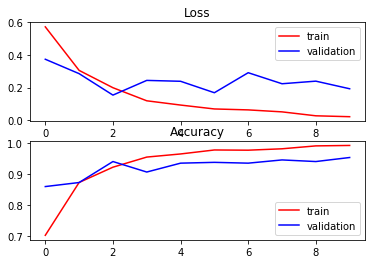

In [61]:
plt.subplot(211)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.show()

In [62]:
final_model_name = get_model_file(DATA_DIR, "resnet50", "l1", "final")
model.save(final_model_name)
test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
final_accuracy = evaluate_model(final_model_name, test_gen)

test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
best_accuracy = evaluate_model(best_model_name, test_gen)

scores[1, 2] = best_accuracy if best_accuracy > final_accuracy else final_accuracy

=== Evaluating model: resnet50-l1-final.h5 ===

Accuracy: 0.915

Confusion Matrix
[[377  51]
 [ 17 355]]

Classification Report
             precision    recall  f1-score   support

          0       0.96      0.88      0.92       428
          1       0.87      0.95      0.91       372

avg / total       0.92      0.92      0.92       800

=== Evaluating model: resnet50-l1-best.h5 ===

Accuracy: 0.910

Confusion Matrix
[[402  24]
 [ 48 326]]

Classification Report
             precision    recall  f1-score   support

          0       0.89      0.94      0.92       426
          1       0.93      0.87      0.90       374

avg / total       0.91      0.91      0.91       800



## Input: Elementwise Euclidean Distance

In [63]:
train_gen = data_generator(train_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
val_gen = data_generator(val_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)

In [64]:
input_1 = Input(shape=(VECTOR_SIZE,))
input_2 = Input(shape=(VECTOR_SIZE,))
merged = Lambda(euclidean_distance, 
                output_shape=euclidean_distance_output_shape)([input_1, input_2])

fc1 = Dense(512, kernel_initializer="glorot_uniform")(merged)
fc1 = Dropout(0.2)(fc1)
fc1 = Activation("relu")(fc1)

fc2 = Dense(128, kernel_initializer="glorot_uniform")(fc1)
fc2 = Dropout(0.2)(fc2)
fc2 = Activation("relu")(fc2)

pred = Dense(2, kernel_initializer="glorot_uniform")(fc2)
pred = Activation("softmax")(pred)

In [65]:
model = Model(inputs=[input_1, input_2], outputs=pred)
# model.summary()

In [66]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [67]:
best_model_name = get_model_file(DATA_DIR, "resnet50", "l2", "best")
checkpoint = ModelCheckpoint(best_model_name, save_best_only=True)
train_steps_per_epoch = len(train_triples) // BATCH_SIZE
val_steps_per_epoch = len(val_triples) // BATCH_SIZE
history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, 
                              epochs=NUM_EPOCHS, 
                              validation_data=val_gen, validation_steps=val_steps_per_epoch,
                              callbacks=[checkpoint])

Epoch 1/10
90/90 [==============================] - 2s - loss: 0.7217 - acc: 0.5681 - val_loss: 0.6145 - val_acc: 0.5964

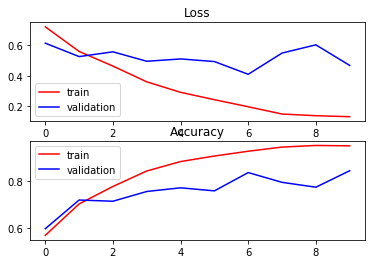

In [68]:
plt.subplot(211)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.show()

In [69]:
final_model_name = get_model_file(DATA_DIR, "resnet50", "l2", "final")
model.save(final_model_name)
test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
final_accuracy = evaluate_model(final_model_name, test_gen)

test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
best_accuracy = evaluate_model(best_model_name, test_gen)

scores[1, 3] = best_accuracy if best_accuracy > final_accuracy else final_accuracy

=== Evaluating model: resnet50-l2-final.h5 ===

Accuracy: 0.816

Confusion Matrix
[[366  58]
 [ 89 287]]

Classification Report
             precision    recall  f1-score   support

          0       0.80      0.86      0.83       424
          1       0.83      0.76      0.80       376

avg / total       0.82      0.82      0.82       800

=== Evaluating model: resnet50-l2-best.h5 ===

Accuracy: 0.804

Confusion Matrix
[[353  72]
 [ 85 290]]

Classification Report
             precision    recall  f1-score   support

          0       0.81      0.83      0.82       425
          1       0.80      0.77      0.79       375

avg / total       0.80      0.80      0.80       800



In [70]:
scores

array([[ 0.90375,  0.9575 ,  0.8925 ,  0.79625],
       [ 0.91625,  0.8975 ,  0.915  ,  0.81625]])

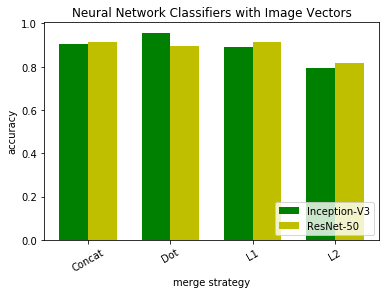

In [71]:
width=0.35
plt.bar(np.arange(scores.shape[1]), scores[0], width, color="g", label="Inception-V3")
plt.bar(np.arange(scores.shape[1])+width, scores[1], width, color="y", label="ResNet-50")
plt.legend(loc=4)
plt.ylabel("accuracy")
plt.xlabel("merge strategy")
plt.xticks(np.arange(scores.shape[1])+0.5*width, ["Concat", "Dot", "L1", "L2"],
          rotation=30)
plt.title("Neural Network Classifiers with Image Vectors")